In [1]:
# import neccessary library
import tensorflow as tf
import statsmodels.api as sm 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Preprocessing Data
# 1.1 Import and Cleansing Data

In [2]:
def read_cleanse_excel(file_name, file_date):
    data = pd.read_excel(file_name)

    # extract date from first column, row 5:end
    date = data.iloc[5:,0].apply(lambda x : pd.to_datetime(file_date + ' ' + str(x)))
    # extract power_kW from 16th column
    power_kW = data.iloc[5:, 16]/1e3

    # create new_frame that is exist only date and power_kW
    new_frame = pd.DataFrame([date,  power_kW])
    new_frame = new_frame.T
    new_frame.columns = ['datetime', 'power_kW']
    new_frame['datetime'] = pd.to_datetime(new_frame['datetime'])
    new_frame = new_frame.set_index(['datetime'])

    # check minor missing data
    if new_frame.shape[0] > 275 and new_frame.shape[0] < 288:
        for i in range(new_frame.shape[0]):
            # identify index of missing data
            dif = (new_frame.index[i+1] - new_frame.index[i]).seconds/60  
            if dif > 5:
                num_mis = round(dif/5 - 1) # amount of missing data

                resolution = (new_frame.iloc[i+1,0] - new_frame.iloc[i,0])/(num_mis+1)

                add_frame = pd.DataFrame({}, columns = ['datetime', 'power_kW'])
                start_new_frame = new_frame.index[i]
                start_new_value = new_frame.iloc[i,0]
                
                for k in range(int(num_mis)):
                    # add delta step 300 sec and value to add_frame
                    start_new_frame = start_new_frame + pd.Timedelta('300 s')
                    start_new_value = start_new_value + resolution
                    
                    add_time = start_new_frame
                    add_value = start_new_value
                    add_frame = pd.concat([add_frame,
                                           pd.DataFrame({'datetime':add_time, 'power_kW':add_value},
                                                        index=[0])])
                # set index to datetime
                add_frame = add_frame.set_index(['datetime'])

                # add add_frame to existing frame and sort by index
                new_frame = pd.concat([new_frame, add_frame])
                new_frame.sort_index(inplace = True)          
        return new_frame, new_frame.shape[0]
    
    # return data immediatly if this day have complete data
    elif new_frame.shape[0] == 288:
        return new_frame, new_frame.shape[0]
    
    # too much value missing return None
    else:
        return None, new_frame.shape[0]

In [3]:
## Retreive all data in the year

date_start = '2013-01-01'
date_temp = date_start
file_name = 'SolarRadiance/' + date_temp + '.xls'

num_stat = []
data, num = read_cleanse_excel(file_name, file_date = date_temp)
num_stat.append(num)

# Loop and import pv data
for i in range(364):
    date_temp = str(pd.to_datetime(date_temp) + pd.Timedelta('1 d'))[0:10]
#     print(date_temp)
               
    file_name = 'SolarRadiance/' + date_temp + '.xls'
    data_day, num = read_cleanse_excel(file_name, file_date = date_temp) 
    
    # if data_day is none, it means that too much values are vanish in this day, skip it
    if data_day is not None:
        data = pd.concat([data, data_day])
    num_stat.append(num)
    

# 1.2 Check remained missing data

In [4]:
new_frame = data.copy()
is_missing = False

for i in range(new_frame.shape[0] - 1):
            # identify index of missing data
            dif = (new_frame.index[i+1] - new_frame.index[i]).seconds/60
            if dif > 5:
                num_mis = dif/5 - 1 # amount of missing data
                print('Time i\t\t',new_frame.index[i])
                print('Time i+1\t',new_frame.index[i+1])
                
                is_missing = True

# 1.3 Remove night time 

In [5]:
# Observe some data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103968 entries, 2013-01-01 00:00:00 to 2013-12-31 23:55:00
Data columns (total 1 columns):
power_kW    51241 non-null float64
dtypes: float64(1)
memory usage: 1.6 MB


In [6]:
# Observe some data
data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103968 entries, 2013-01-01 00:00:00 to 2013-12-31 23:55:00
Data columns (total 1 columns):
power_kW    103968 non-null float64
dtypes: float64(1)
memory usage: 1.6 MB


In [7]:
## Define night time by --> set(whole_day_time) - set(day_time)
'''
This cell will calculate result dataframe which merge is_daytime boolean
'''
# Group data by day
data_grouped = data.groupby(pd.Grouper(freq='D'))
group_keys = data_grouped.groups.keys()

date_start = pd.to_datetime('2013-01-01 00:00:00')
pv_day = data_grouped.get_group(date_start)
day_time = pv_day != 0

count = 0
for key in group_keys:
    
    # Some day is missing and raise an error if key is the missing day
    # so except that missing day using try, except
    try:
        pv_day_temp = data_grouped.get_group(key)
        
        # find first and last index of day time for every day
        for i in range(288):
            if abs(pv_day_temp.iloc[i,0]) > 10e-4:
                first_index = i
                break
        for i in range(287,-1,-1):
            if abs(pv_day_temp.iloc[i,0]) > 10e-4:
                last_index = i
                break
        
        day_time = pv_day_temp.copy()
        # Define is_daytime
        day_time.iloc[first_index:last_index,0] = True
        day_time.iloc[:first_index-1,0] = False
        day_time.iloc[last_index-1:,0] = False
        
        # merge is_daytime to data
        day_time.index = pv_day_temp.index
        day_time.columns = ['is_daytime']
        
        if count == 0:
            result = pd.merge(pv_day_temp, day_time, left_index=True, right_index=True)
        else:
            result = pd.concat([result,
                                pd.merge(pv_day_temp, day_time, left_index=True, right_index=True)])
        count += 1
    except KeyError:
        pass

## Visualize result
result

,power_kW,is_daytime
datetime,,
2013-01-01 00:00:00,0.0,False
2013-01-01 00:05:00,0.0,False
2013-01-01 00:10:00,0.0,False
2013-01-01 00:15:00,0.0,False
2013-01-01 00:20:00,0.0,False
2013-01-01 00:25:00,0.0,False
2013-01-01 00:30:00,0.0,False
2013-01-01 00:35:00,0.0,False
2013-01-01 00:40:00,0.0,False


In [8]:
'''
Now it's time to remove night time by removing False row of is_daytime columns!
'''
# Group result data by day
data_daytime = result.loc[result['is_daytime']==True,:]
for i in range(len(data_daytime)):
    print(data_daytime.iloc[i,0])

0.02779
0.04902
0.07209
0.09013
0.10483
0.11588
0.15139
0.17766
0.2468
0.29613
0.2903
0.25008
0.23051
0.246
0.20465
0.33846
0.29104
0.3896
0.43225
0.48315
0.40645
0.4318
0.41355
0.4048
0.23721
0.43727
0.67926
0.68114
0.68376
0.66315
0.48666
0.6279
0.77184
0.76363
0.77102
0.76127
0.76951
0.75527
0.7778
0.78982
0.77825
0.82312
0.85116
0.83391
0.84428
0.85074
0.86933
0.88647
0.88405
0.87565
0.85022
0.8615
0.88843
0.91724
0.91918
0.93611
0.94367
0.8782
0.89587
0.90388
0.895
0.89822
0.89218
0.88198
0.87061
0.85924
0.86313
0.86169
0.84476
0.83523
0.85621
0.83073
0.81769
0.88
0.82278
0.61343
0.63778
0.59696
0.56493
0.77625
0.82604
0.79431
0.70955
0.74289
0.74787
0.71471
0.68058
0.68804
0.69293
0.67692
0.66816
0.64115
0.61561
0.61498
0.595
0.57165
0.55905
0.53753
0.52064
0.50007
0.48445
0.46412
0.44122
0.42556
0.40079
0.37775
0.34109
0.31743
0.2966
0.27852
0.23355
0.20518
0.20764
0.17273
0.14705
0.13118
0.11482
0.08925
0.05322
0.0202
0.00556
0.00762
0.0138
0.01735
0.02329
0.03063
0.04189
0.053

0.69065
0.70409
0.68533
0.66574
0.65056
0.65064
0.64493
0.62461
0.60462
0.57853
0.575335
0.57214
0.54865
0.53943
0.51988
0.48691
0.47067
0.45278
0.42732
0.39916
0.35916
0.31638
0.29242
0.27337
0.25176
0.22829
0.18956
0.16013
0.14966
0.12723
0.04947
0.004
0.00691
0.00719
0.007
0.01166
0.01639
0.02264
0.03865
0.06049
0.10785
0.16304
0.21211
0.27836
0.31418
0.33909
0.36593
0.39084
0.41771
0.43992
0.46317
0.48719
0.4986
0.51435
0.53125
0.54964
0.57026
0.59548
0.61513
0.64564
0.6675
0.67969
0.6751
0.68683
0.71162
0.72043
0.73196
0.76017
0.75629
0.75731
0.77427
0.7702
0.77698
0.79702
0.83807
0.86004
0.842
0.85992
0.85458
0.8538
0.86188
0.86842
0.87207
0.87318
0.879665
0.88615
0.8802
0.88157
0.87927
0.86838
0.87951
0.88367
0.86209
0.86776
0.88269
0.88749
0.905
0.90671
0.90006
0.89971
0.89846
0.92783
0.93835
0.92234
0.91638
0.9384
0.92805
0.90218
0.90836
0.89663
0.89255
0.89196
0.88465
0.87869
0.85392
0.849
0.84263
0.82507
0.82305
0.82905
0.81389
0.79775
0.76638
0.76465
0.75483
0.74107
0.74116

0.61164
0.60354
0.59785
0.60553
0.59231
0.57173
0.5797
0.5853
0.58705
0.58527
0.57322
0.553
0.54829
0.55719
0.54163
0.54045
0.53187
0.51855
0.51058
0.52135
0.50441
0.48656
0.48344
0.47869
0.46867
0.45076
0.4404
0.4258
0.41018
0.39289
0.38305
0.37217
0.36063
0.34455
0.33171
0.31572
0.29698
0.27997
0.26225
0.24187
0.22839
0.20896
0.19818
0.17571
0.16111
0.14513
0.12395
0.10953
0.0894
0.07484
0.06173
0.03888
0.02135
0.00502
0.0182
0.04525
0.06475
0.07347
0.10773
0.13105
0.12798
0.14098
0.16061
0.19067
0.2148
0.203
0.2608
0.27788
0.24306
0.17531
0.18577
0.26787
0.2152
0.22351
0.21025
0.34161
0.38334
0.37562
0.394
0.35479
0.45628
0.4053
0.24504
0.23879
0.45461
0.30462
0.29702
0.30377
0.52447
0.40324
0.52493
0.53229
0.53467
0.55829
0.5034
0.52985
0.53548
0.3942
0.32591
0.58631
0.56992
0.4745
0.54585
0.46727
0.52153
0.478525
0.43552
0.6066
0.45303
0.57868
0.36713
0.18251
0.26695
0.48889
0.45127
0.46493
0.49709
0.50425
0.36608
0.46171
0.39644
0.38065
0.37432
0.37633
0.3582
0.32216
0.45048
0.40

0.65151
0.62704
0.68627
0.65405
0.75292
0.74073
0.57296
0.69676
0.60665
0.65002
0.64837
0.63397
0.61749
0.55438
0.50738
0.46516
0.47473
0.4923
0.4743
0.44944
0.40695
0.31465
0.26636
0.28498
0.24305
0.32905
0.30068
0.27635
0.2437
0.18239
0.2142
0.23251
0.21489
0.19598
0.1832
0.16325
0.13414
0.11277
0.09793
0.07202
0.05561
0.0335
0.00589
0.01075
0.01422
0.00931
0.0414
0.07798
0.09455
0.12863
0.14531
0.17364
0.18672
0.22453
0.14424
0.11204
0.185
0.16594
0.23253
0.17444
0.17676
0.4214
0.45318
0.49947
0.5318
0.57308
0.56876
0.63553
0.63825
0.66106
0.48662
0.41062
0.51587
0.57377
0.50549
0.71605
0.84485
0.56264
0.60475
0.49448
0.79942
0.60755
0.76689
0.82225
0.71069
0.47275
0.40118
0.70696
0.71319
0.61791
0.97622
0.62393
0.49706
0.30862
0.31544
0.66857
0.63316
0.47969
0.50362
0.51311
0.48124
0.49388
0.69273
1.063
0.92664
0.96379
0.65385
0.83707
0.87858
0.618
0.81992
0.72258
0.9558
0.93061
0.93598
0.91936
0.92007
0.93289
0.94297
0.9181
0.87645
0.906
0.89082
0.83189
0.80047
0.83572
0.89629
0.8

0.88111
0.88458
0.88194
0.8788
0.87624
0.86933
0.86351
0.85421
0.84021
0.82027
0.80951
0.799
0.78909
0.77636
0.72424
0.698
0.75564
0.73512
0.68798
0.71847
0.6891
0.67256
0.66516
0.64344
0.6195
0.60454
0.57056
0.50205
0.46629
0.35529
0.21959
0.10375
0.08176
0.07713
0.07971
0.08963
0.09933
0.09625
0.06415
0.02587
0.0066
0.0076
0.00814
0.00548
0.01415
0.02563
0.03722
0.06422
0.08057
0.10154
0.12408
0.1444
0.16685
0.19166
0.21902
0.25022
0.27814
0.31819
0.35796
0.4036
0.42178
0.44098
0.43178
0.43384
0.4634
0.42546
0.38831
0.50084
0.40522
0.57847
0.58187
0.59313
0.62659
0.63733
0.6643
0.660965
0.65763
0.72286
0.73491
0.72841
0.68051
0.6453
0.78764
0.79285
0.80342
0.81177
0.82955
0.83076
0.84238
0.85267
0.86165
0.87442
0.87875
0.89119
0.89539
0.8937
0.8922
0.90407
0.90414
0.91323
0.91955
0.92776
0.93411
0.92856
0.93445
0.93064
0.91289
0.92827
0.93872
0.93591
0.95513
0.95887
0.94558
0.57653
0.07144
0.90283
0.90044
0.91333
0.91628
0.90596
0.89198
0.89448
0.89965
0.899075
0.8985
0.89518
0.90006

0.75698
0.69992
0.69362
0.68538
0.64164
0.60475
0.58275
0.57576
0.5673
0.52151
0.51461
0.49117
0.51798
0.52445
0.51982
0.53896
0.53189
0.53085
0.48278
0.45059
0.4257
0.41683
0.42265
0.3756
0.35033
0.351
0.33041
0.33715
0.352
0.30427
0.32695
0.33455
0.35383
0.25815
0.23609
0.29269
0.21651
0.19098
0.19427
0.18722
0.17455
0.15529
0.13974
0.13848
0.12484
0.09624
0.0743
0.07113
0.05362
0.03578
0.03359
0.02693
0.01745
0.0315
0.04342
0.04709
0.05076
0.05573
0.05627
0.05805
0.08574
0.13595
0.14729
0.14014
0.1716
0.21618
0.28918
0.23448
0.19991
0.24145
0.21847
0.25169
0.32961
0.28319
0.24305
0.20461
0.28448
0.35732
0.36054
0.33864
0.35745
0.35767
0.36859
0.4038
0.38039
0.37235
0.43178
0.47562
0.55689
0.59056
0.4956
0.55732
0.62438
0.37287
0.27815
0.43252
0.30597
0.2982
0.71298
0.63339
0.384
0.28978
0.16131
0.24998
0.18967
0.28215
0.30747
0.4215
0.67931
0.75588
0.77536
0.84672
0.87493
0.63976
0.7178
0.81513
0.799
0.53549
0.57463
0.58055
0.53691
0.32656
0.29536
0.39175
0.35058
0.33562
0.34109
0.1

0.35425
0.32648
0.3072
0.29653
0.28189
0.27383
0.26215
0.24339
0.22262
0.21048
0.18583
0.17581
0.16373
0.14734
0.12562
0.09893
0.07679
0.05742
0.03538
0.01689
0.04034
0.05627
0.06521
0.08193
0.11262
0.10293
0.0757
0.0436
0.05262
0.04093
0.00689
0.03518
0.0349
0.0516
0.08513
0.08505
0.06869
0.03209
0.01632
0.00092
0.0
0.08177
0.16162
0.2302
0.2638
0.29291
0.30384
0.30884
0.3263
0.32288
0.32305
0.34579
0.40015
0.44227
0.45929
0.52382
0.55433
0.54729
0.47885
0.46898
0.55402
0.57391
0.55434
0.46484
0.52514
0.49753
0.61793
0.68725
0.78416
0.85736
0.78346
0.79338
0.671
0.71288
0.74802
0.59192
0.47469
0.47032
0.48963
0.52073
0.47077
0.4334
0.44329
0.46285
0.45744
0.523
0.54789
0.59289
0.60707
0.77538
0.94865
0.56223
0.87788
0.95947
1.02209
1.07466
0.98387
0.85192
0.84119
0.76803
0.43021
0.52924
0.59756
0.47429
0.54926
0.6034
0.57974
0.55714
0.54005
0.49833
0.45104
0.4292
0.40429
0.40146
0.43091
0.46609
0.52096
0.532
0.45393
0.41487
0.40462
0.415
0.41622
0.4217
0.4337
0.45293
0.42121
0.3566
0.

0.83432
0.84283
0.85198
0.84045
0.82769
0.82049
0.84323
0.84992
0.84158
0.77329
0.84078
0.82767
0.81658
0.80014
0.79976
0.79829
0.7925
0.77805
0.77309
0.75246
0.74394
0.74056
0.71117
0.70209
0.69391
0.68176
0.67158
0.65053
0.63756
0.62369
0.60865
0.59564
0.5803
0.55713
0.5418
0.52632
0.50595
0.49309
0.47743
0.45315
0.43861
0.42565
0.40573
0.38321
0.3617
0.33313
0.31152
0.2968
0.27238
0.24883
0.21719
0.19288
0.16761
0.14515
0.1255
0.10262
0.0848
0.07031
0.05381
0.02661
0.00859
0.01066
0.02618
0.04039
0.05753
0.07073
0.08607
0.10028
0.11226
0.12963
0.13929
0.16637
0.18093
0.14748
0.25098
0.27548
0.29124
0.30806
0.32124
0.33555
0.3643
0.37644
0.39941
0.41447
0.41
0.42498
0.44338
0.48465
0.51793
0.53145
0.54481
0.54994
0.55774
0.56917
0.59047
0.58908
0.60982
0.63579
0.63457
0.6166
0.60922
0.63655
0.66417
0.69137
0.73749
0.7934
0.78944
0.78548
0.70825
0.78476
0.80507
0.81193
0.82656
0.83692
0.8387
0.83715
0.83452
0.82969
0.83661
0.84305
0.84244
0.85198
0.86138
0.85411
0.85011
0.84277
0.8473

0.36336
0.33327
0.36002
0.34043
0.33836
0.3332
0.25289
0.28535
0.34067
0.39411
0.41796
0.41495
0.40867
0.399945
0.39122
0.38148
0.37098
0.36955
0.38074
0.38235
0.37544
0.37873
0.38025
0.37633
0.37195
0.35652
0.3466
0.34276
0.33245
0.35045
0.34204
0.34739
0.34718
0.32548
0.28952
0.26463
0.24609
0.23261
0.22517
0.21381
0.20515
0.1946
0.18314
0.17452
0.1702
0.16198
0.15111
0.13772
0.12527
0.11513
0.10418
0.09711
0.09045
0.07855
0.07214
0.0604
0.04613
0.03637
0.01994
0.02625
0.09395
0.08574
0.03324
0.08484
0.14636
0.1823
0.13785
0.20375
0.22294
0.17576
0.19684
0.3273
0.35163
0.31607
0.36569
0.34747
0.35486
0.28875
0.263
0.28324
0.2328
0.20664
0.21369
0.27771
0.28002
0.39836
0.39227
0.31622
0.3748
0.29978
0.67546
0.52281
0.40364
0.38773
0.71975
0.75074
0.67158
0.50904
0.65574
0.73298
0.74556
0.76489
0.56107
0.68473
0.70804
0.71745
0.71556
0.85589
0.81596
0.65973
0.51209
0.73406
0.94314
0.71253
0.70812
0.90465
0.79776
0.4486
0.32343
0.29815
0.43136
0.29461
0.13474
0.09248
0.10802
0.15978
0.1

0.13945
0.15727
0.1774
0.21367
0.19653
0.15408
0.13085
0.15697
0.23798
0.23685
0.23146
0.23721
0.28506
0.34484
0.38803
0.43845
0.2997
0.2811
0.29629
0.32567
0.3426
0.32836
0.29657
0.31245
0.19984
0.15936
0.16646
0.23242
0.32309
0.4798
0.50436
0.66353
0.32735
0.2284
0.18634
0.16768
0.27631
0.25696
0.27235
0.22195
0.34115
0.21382
0.24351
0.24046
0.16105
0.18538
0.15211
0.13463
0.2172
0.36829
0.37977
0.45888
0.57381
0.48798
0.47837
0.44318
0.31482
0.29768
0.25773
0.21352
0.22729
0.30555
0.352
0.3634
0.3642
0.3539
0.37579
0.3752
0.26186
0.33636
0.3424
0.3543
0.416
0.51953
0.67027
0.45938
0.40753
0.40404
0.61861
0.49288
0.32538
0.27524
0.20569
0.16575
0.18667
0.20013
0.22267
0.27698
0.45427
0.57806
0.53171
0.51247
0.37909
0.37147
0.35845
0.42106
0.2946
0.249
0.22398
0.20607
0.18233
0.15616
0.10044
0.05151
0.02378
0.01416
0.0144
0.00252
0.0
0.00193
0.00992
0.00806
0.01151
0.02396
0.03073
0.04925
0.06925
0.08293
0.08782
0.09471
0.09804
0.10316
0.10377
0.10263
0.1071
0.11424
0.11569
0.12369
0.

0.11979
0.10029
0.09311
0.06354
0.03935
0.02213
0.01104
0.00745
0.01916
0.0311
0.0308
0.03113
0.00385
0.00905
0.01642
0.02111
0.02879
0.04125
0.05274
0.06587
0.08135
0.08826
0.07664
0.07079
0.09902
0.13672
0.16359
0.16957
0.18146
0.19702
0.17831
0.17502
0.19395
0.21395
0.23387
0.25619
0.27076
0.27809
0.282
0.28637
0.3018
0.31425
0.3615
0.40261
0.45829
0.50509
0.484
0.46541
0.48798
0.43854
0.42495
0.41676
0.40594
0.38638
0.33858
0.36453
0.3502
0.34662
0.33756
0.36366
0.42342
0.44406
0.4146
0.42278
0.449
0.44829
0.44366
0.39751
0.34902
0.45054
0.66448
0.52327
0.4889
0.48591
0.47489
0.47594
0.48278
0.73453
0.77667
0.8318
0.726
0.9072
0.41977
0.469
0.60311
0.60108
0.40926
0.67611
0.67829
0.89923
0.55275
0.39274
0.41449
0.40696
0.56945
0.52008
0.36833
0.44559
0.61608
0.63415
0.46551
0.44943
0.31544
0.22155
0.22346
0.10987
0.12902
0.21956
0.37664
0.56181
0.41218
0.30637
0.25607
0.233
0.27334
0.31122
0.36055
0.2913
0.16886
0.015
0.00033
0.0
0.0
0.00044
0.0
0.00036
0.0
0.0
0.0071
0.01131
0.010

0.00041
0.0
0.00037
0.0
0.0
0.0
0.0
0.00027
0.0
0.0
0.00043
0.0
0.00055
0.0
0.0
0.00032
0.0
0.00045
0.0
0.00033
0.0
0.00048
0.0
7e-05
0.00014
0.0
0.00814
0.02077
0.02629
0.01862
0.0074
0.02022
0.02616
0.03542
0.04927
0.06202
0.07917
0.08964
0.11086
0.13231
0.17809
0.16979
0.17789
0.19267
0.19834
0.21093
0.21062
0.2195
0.23804
0.25811
0.31581
0.43929
0.45393
0.34417
0.27233
0.28522
0.31991
0.42595
0.50882
0.51089
0.48575
0.49627
0.5076
0.50615
0.50733
0.47087
0.45202
0.45648
0.43518
0.47604
0.48557
0.53132
0.59418
0.63436
0.72364
0.83952
0.78456
0.7712
0.73626
0.79396
0.73087
0.63925
0.56184
0.55221
0.72692
0.84104
0.86287
0.7678
0.61053
0.61137
0.64478
0.64473
0.70395
0.59636
0.85284
0.86724
0.83947
0.83031
0.80327
0.75362
0.77984
0.86354
0.84603
0.91252
0.7231
0.70664
0.93105
0.89639
0.8946
0.84215
0.88335
0.76975
0.64753
0.63593
0.77087
0.52553
0.68686
0.53443
0.67328
0.70594
0.6617
0.70124
0.62098
0.77575
0.55098
0.60054
0.53296
0.62566
0.59145
0.5933
0.4763
0.43739
0.5022
0.4201
0.

0.14937
0.23114
0.22117
0.19006
0.20269
0.48587
0.52375
0.45916
0.40477
0.1869
0.3722
0.33296
0.30104
0.27867
0.25
0.22941
0.20729
0.1236
0.1703
0.15069
0.12124
0.08194
0.0135
0.02433
0.03213
0.04054
0.0578
0.06475
0.06619
0.06844
0.08417
0.09748
0.12173
0.14746
0.27998
0.44973
0.36298
0.27868
0.26643
0.28062
0.25551
0.24453
0.36055
0.2474
0.36042
0.30811
0.3154
0.42865
0.35611
0.3434
0.38508
0.37537
0.38062
0.375
0.3778
0.36363
0.45195
0.48186
0.65
0.69075
0.74271
0.66759
0.66076
0.68675
0.69553
0.5868
0.6466
0.47856
0.78982
0.94276
0.66872
0.81253
0.83438
0.80756
0.65186
0.52158
0.94711
0.66421
0.7713
0.92478
0.9426
0.91096
0.62229
0.42479
0.57788
0.47656
0.4382
0.38814
0.5308
0.21684
0.89383
1.03249
0.61992
0.80279
0.9616
0.85993
0.5952
0.52856
0.9804
0.98629
0.62822
0.265
0.94833
0.35405
1.03364
0.74976
0.57014
0.80376
0.8507
0.86538
0.92497
0.87636
0.89982
0.56441
0.43088
0.33216
0.36703
0.66758
0.75442
0.5739
0.47398
0.65469
0.752
0.68459
0.37639
0.75834
0.76809
0.69796
0.35112
0

0.16098
0.14871
0.14374
0.12657
0.11742
0.11322
0.08128
0.07138
0.07149
0.06452
0.056
0.04063
0.01733
0.00615
0.01656
0.02495
0.03045
0.0368
0.05503
0.07316
0.09421
0.10686
0.11593
0.12208
0.13132
0.13217
0.12066
0.11795
0.11505
0.1174
0.13138
0.14152
0.14453
0.14415
0.15004
0.1673
0.18745
0.21165
0.23827
0.2562
0.26826
0.27108
0.27149
0.27072
0.27398
0.27685
0.275
0.26271
0.25509
0.26679
0.26862
0.2754
0.28892
0.31639
0.34411
0.35666
0.36048
0.36496
0.33707
0.31385
0.31196
0.33592
0.36325
0.3678
0.36295
0.35498
0.3545
0.3594
0.375415
0.39143
0.41775
0.42676
0.42828
0.40768
0.36763
0.37314
0.36971
0.3309
0.25495
0.23531
0.14149
0.12745
0.12012
0.1079
0.11111
0.1202
0.13158
0.14913
0.17269
0.19531
0.1983
0.21984
0.20821
0.17268
0.14816
0.13575
0.12104
0.11727
0.11509
0.12056
0.12698
0.12444
0.1129
0.10615
0.10205
0.09602
0.09395
0.08669
0.07637
0.07154
0.07138
0.07041
0.07056
0.06682
0.06283
0.05619
0.03985
0.03213
0.03447
0.03237
0.03488
0.03644
0.038
0.04407
0.04793
0.05036
0.05271
0.

0.09455
0.10088
0.12796
0.16442
0.19737
0.24295
0.28278
0.285
0.24006
0.27414
0.30198
0.33612
0.40723
0.57698
0.45276
0.33724
0.28833
0.2343
0.31897
0.3044
0.5354
0.67578
0.71005
0.73225
0.45347
0.3496
0.61938
0.51767
0.36683
0.35128
0.31636
0.12945
0.08365
0.05923
0.06295
0.09698
0.13742
0.19021
0.251
0.25044
0.27874
0.66811
0.94741
0.86783
0.52612
0.67422
0.82093
0.26715
0.26252
0.2323
0.15976
0.14188
0.25121
0.17618
0.12831
0.09549
0.07863
0.06581
0.06889
0.05984
0.08622
0.10805
0.14415
0.20735
0.25577
0.75439
0.6247
0.74248
0.45458
0.33082
0.45485
0.40402
0.29145
0.11498
0.03158
0.00862
0.0052
0.00045
0.0
0.00044
0.0
0.00044
0.0
0.00044
0.0
0.0059
0.04559
0.04262
0.04919
0.0192
0.01036
0.006
0.006
0.006
0.006
0.00155
0.0
0.00047
0.0
0.00033
0.00011
0.0
0.00032
0.0
0.0
0.0
0.00045
0.0
0.00045
0.0
0.0
0.00135
0.0
0.00459
0.0116
0.0052
0.01919
0.03648
0.03955
0.0532
0.09424
0.11071
0.12806
0.15687
0.15585
0.15341
0.14832
0.13324
0.08413
0.10515
0.16415
0.27087
0.38869
0.44059
0.43922


0.14556
0.31369
0.54679
0.44259
0.67213
0.81079
0.81872
0.79912
0.55349
0.15021
0.13389
0.13591
0.14806
0.28337
0.37974
0.26469
0.31496
0.33009
0.24746
0.53593
0.60146
0.52137
0.20516
0.34759
0.55921
0.48618
0.216
0.09155
0.10533
0.06922
0.041
0.04646
0.06083
0.07817
0.0559
0.00845
0.02452
0.04045
0.05951
0.08062
0.09387
0.1029
0.1252
0.15817
0.17968
0.20924
0.23991
0.26774
0.28982
0.31813
0.34103
0.36573
0.38889
0.41253
0.43654
0.45743
0.4768
0.5012
0.52156
0.54214
0.55963
0.58504
0.60748
0.61446
0.62322
0.6368
0.64195
0.68745
0.70652
0.71845
0.72045
0.7262
0.74989
0.76515
0.78564
0.817
0.82274
0.83193
0.84023
0.83094
0.8442
0.84855
0.85753
0.86306
0.87562
0.86162
0.87527
0.89779
0.9055
0.92093
0.92598
0.92332
0.93057
0.93459
0.89749
0.79141
0.92643
0.94367
0.88593
0.93261
0.89329
0.92285
0.9173
0.90765
0.90843
0.92103
0.87633
0.30339
0.94348
0.93175
0.91285
0.89505
0.89672
0.91078
0.91556
0.90733
0.89692
0.88045
0.8712
0.87215
0.87076
0.84296
0.82324
0.81836
0.78702
0.78853
0.76602
0

0.2797
0.26053
0.23133
0.20868
0.19002
0.18583
0.19313
0.22787
0.29507
0.28024
0.26918
0.32169
0.29343
0.23622
0.13467
0.15104
0.13927
0.13667
0.12184
0.15311
0.16598
0.13655
0.16215
0.17838
0.22818
0.21538
0.22391
0.17779
0.17423
0.18061
0.14659
0.13283
0.19436
0.23345
0.22008
0.12812
0.13113
0.13254
0.13513
0.093
0.0491
0.02789
0.02984
0.04878
0.06845
0.06221
0.03047
0.00509
0.01782
0.02656
0.0366
0.04689
0.06029
0.06968
0.10567
0.15684
0.19967
0.23909
0.27905
0.29194
0.3082
0.31887
0.32042
0.37119
0.42166
0.43377
0.48146
0.48818
0.50247
0.52153
0.53721
0.5829
0.58154
0.60319
0.61193
0.65015
0.64367
0.64641
0.64317
0.64848
0.68444
0.71855
0.72495
0.73451
0.74736
0.78862
0.79982
0.78882
0.84325
0.56391
0.85861
0.88943
0.89956
0.837
0.82986
0.72553
0.74767
0.42054
0.1332
0.17579
0.24335
0.41296
0.46181
0.42249
0.43361
0.91856
0.45842
0.64684
0.39329
0.48354
0.55555
0.2324
0.18402
0.2671
0.17138
0.0679
0.04927
0.04426
0.0229
0.00694
0.00485
0.00011
0.0
0.00253
0.0
0.00565
0.02198
0.0263

0.22107
0.32763
0.95368
0.46558
0.26991
0.25014
0.26815
0.43137
0.88354
0.25581
0.22748
0.22358
0.25137
0.47611
0.83393
0.83693
0.80625
0.3304
0.19966
0.18279
0.2283
0.78659
0.54232
0.29593
0.18709
0.19249
0.18711
0.61946
0.60289
0.58274
0.47883
0.50986
0.51702
0.48496
0.45345
0.42964
0.42341
0.39291
0.20669
0.39638
0.3341
0.29228
0.26556
0.26392
0.25357
0.2146
0.19654
0.17627
0.14779
0.12941
0.1066
0.08028
0.04221
0.01856
0.01557
0.04282
0.04526
0.053
0.0592
0.06035
0.08382
0.10269
0.09267
0.10726
0.16123
0.16956
0.19853
0.26863
0.15625
0.42162
0.2222
0.23781
0.34088
0.42009
0.53216
0.64231
0.60443
0.59348
0.61808
0.63058
0.63668
0.66055
0.66384
0.66523
0.61229
0.73871
0.71554
0.59046
0.74587
0.76465
0.77653
0.78729
0.71764
0.79727
0.80243
0.79396
0.81369
0.83051
0.82877
0.85822
0.85685
0.87173
0.84688
0.87396
0.88185
0.89572
0.90122
0.9137
0.88811
0.78986
0.83703
0.67918
0.63595
0.39096
0.91611
0.8688
0.9892
0.92207
0.79795
0.66006
0.64005
0.52989
0.50913
0.61529
0.27241
0.30267
0.90

(0, 500)

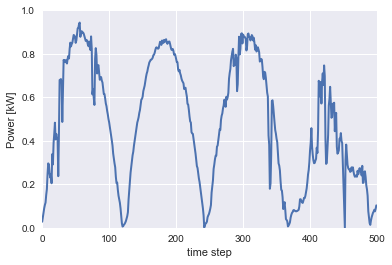

In [9]:
# Visualize suk nid

steps = 500
y = data_daytime.iloc[:steps,0]
x = np.arange(steps)
plt.plot(x,y, linewidth='2')

plt.xlabel('time step')
plt.ylabel('Power [kW]')
plt.ylim([0,1])
plt.xlim([0,500])

<em> Finally night time is removed! </em>

# 2. Preprocessing 2

# 2.1 Categorize sunny, cloudy and rainy day

In [10]:
'''
This part will categorize sunny, cloudy and rainy day using k-means clustering
First we will observe data on sunny day, cloudy day and rainy day manually
'''

data_daytime_grouped = data_daytime.groupby(pd.Grouper(freq='D'))

# energy by day
avg = data_daytime_grouped.sum()/12
avg.columns = ['Energy_kWh']

# standard by day
std = data_daytime_grouped.std()
std.columns = ['std']

mean = data_daytime_grouped.mean()
max_ = data_daytime_grouped.max().iloc[:,0]

# load factor by day
lf_val = np.divide(mean.as_matrix(), max_.as_matrix())
lf = mean.copy()
lf.columns = ['Load_Factor']
lf['Load_Factor'] = lf_val


# max power change rate
group_keys = data_daytime_grouped.groups.keys()
p_ramp = lf.copy()
p_ramp.columns = ['ramp']

count = 0
for key in group_keys:
    
    # Some day is missing and raise an error if key is the missing day
    # so except that missing day using try, except
    try:
        pv_daytime = data_daytime_grouped.get_group(key)
        pv_t = np.array(pv_daytime.iloc[:-1,0])
        pv_t_1= np.array(pv_daytime.iloc[1:,0])
        max_ramp = np.max(np.abs(pv_t-pv_t_1))
#         print(p_ramp)
        p_ramp.iloc[count,0] = max_ramp
        count += 1
        
    except KeyError:
        count += 1

p_ramp = p_ramp.dropna()
lf = lf.dropna()
std = std.dropna()
avg = avg.dropna()
## End cal p_ramp

idx_dict = {'max_val':0, 'max_index':0, 'min_val':500, 'min_index':0}

for idx in range(len(avg)):
    
    if avg.iloc[idx,0] > idx_dict['max_val']:
        idx_dict['max_val'] = avg.iloc[idx,0]
        idx_dict['max_index'] = avg.index[idx]
        
    if avg.iloc[idx,0] < idx_dict['min_val']:
        idx_dict['min_val'] = avg.iloc[idx,0]
        idx_dict['min_index'] = avg.index[idx]
        

Max Day std 0.3138031912941027
Min Day std 0.04108009564891512


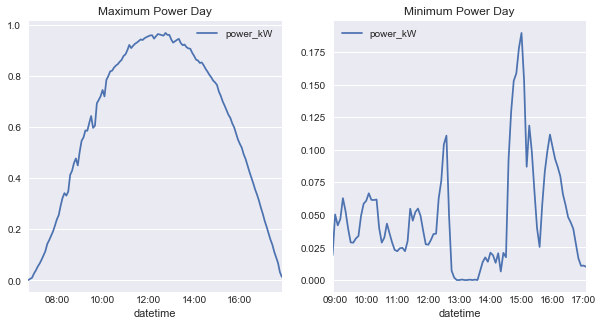

In [11]:
'''
from idx_dict, let's plot profile of min energy day and max energy day
'''

fig, ax = plt.subplots(1,2, figsize=(10,5))
data_daytime_grouped.get_group(idx_dict['max_index']).plot(y=['power_kW'],
                                                           ax = ax[0],
                                                           title='Maximum Power Day')
print('Max Day std', data_daytime_grouped.get_group(idx_dict['max_index'])['power_kW'].std())
data_daytime_grouped.get_group(idx_dict['min_index']).plot(y=['power_kW'],
                                                           ax = ax[1],
                                                           title='Minimum Power Day')
print('Min Day std', data_daytime_grouped.get_group(idx_dict['min_index'])['power_kW'].std())

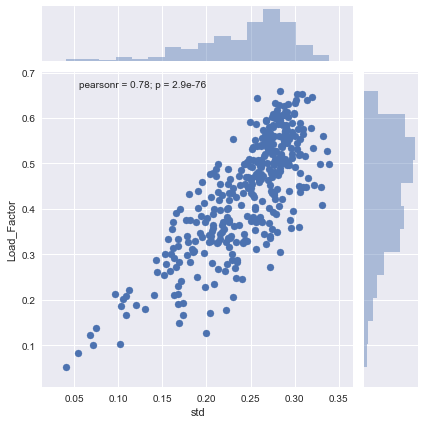

In [12]:
sns.jointplot(std.iloc[:,0],lf.iloc[:,0])

<bold> From Energy kWh vs std Plot ...</bold>

In [15]:
# combine avg and std
avg_std = pd.merge(avg, std, left_index = True, right_index=True)
avg_std_lf = pd.merge(avg_std, lf, left_index = True, right_index=True)
avg_std_ramp =pd.merge(avg_std, p_ramp, left_index = True, right_index=True)
avg_ramp = pd.merge(avg, p_ramp, left_index = True, right_index=True)
avg_std_lf_ramp = pd.merge(avg_std_lf, p_ramp, left_index = True, right_index=True)

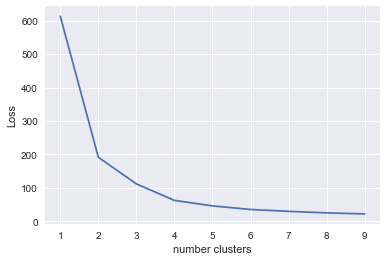

In [16]:
from sklearn.cluster import KMeans

X = avg_std_lf_ramp.loc[np.logical_not(avg['Energy_kWh'].isnull()),:].as_matrix()
X = X.reshape(X.shape[0],-1)

loss_arr = []
for i in range(1,10):
    n_clusters = i
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    loss_arr.append(kmeans.inertia_)

plt.plot(np.arange(n_clusters)+1, loss_arr)
plt.xlabel('number clusters')
plt.ylabel('Loss')

In [17]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters).fit(X)

group_clus = kmeans.predict(X)
print(kmeans.inertia_)
# avg = avg.dropna()

62.7093939117


In [18]:
all_group = []
for i in range(n_clusters):
    
    all_group.append(avg.index[group_clus==i])
    print('group_{:d} size: {:d}'.format(i, all_group[i].shape[0]))

group_0 size: 99
group_1 size: 102
group_2 size: 121
group_3 size: 39


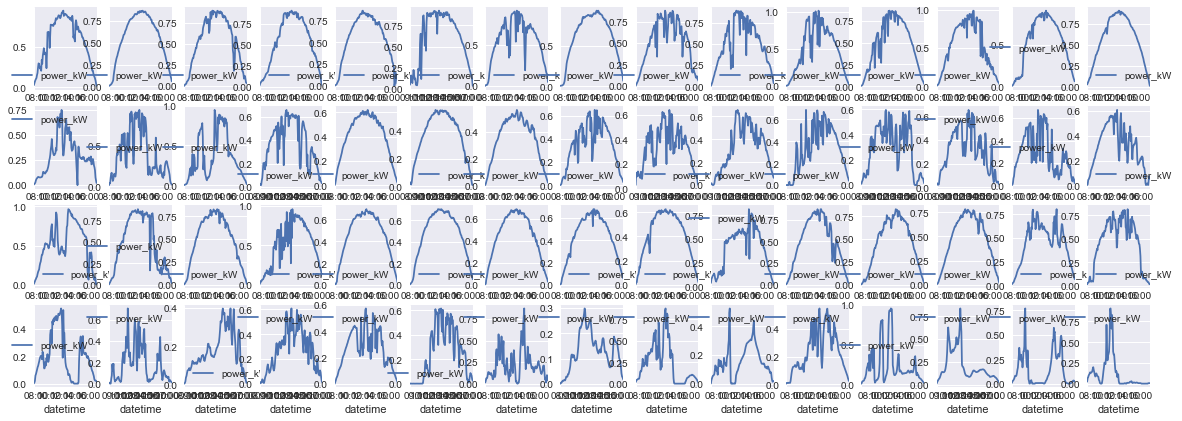

In [19]:
num_plot = 15
fig, ax = plt.subplots(n_clusters,num_plot, figsize=(20,7))

for i in range(num_plot):
    for k in range(len(all_group)):
        data_daytime_grouped.get_group(all_group[k][i]).plot(y = 'power_kW', ax=ax[k,i])

<strong> Now Each cluster can be represented as sunny, rainy and cloudy day! </strong>

In [20]:
# extract data of each group from all group
# data group
data_group_all = []

for i in range(n_clusters):
    
    # extract data from each group
    data_group_i = data_daytime_grouped.get_group(all_group[i][0])
    for k in range(all_group[i].shape[0]-1):
        data_group_i =  pd.concat([data_group_i, data_daytime_grouped.get_group(all_group[i][k+1])])
        
    data_group_all.append(data_group_i)
    
data_group_all[n_clusters-1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4741 entries, 2013-01-23 07:40:00 to 2013-11-24 17:10:00
Data columns (total 2 columns):
power_kW      4741 non-null float64
is_daytime    4741 non-null object
dtypes: float64(1), object(1)
memory usage: 111.1+ KB


# 2.2 Prepare input and output of time-series
<em> Create Method for prepare input and output of time series </em>

In [21]:
def get_batch(X, steps, cur_index):
    '''
    This method will generate input and output of time-series for RNN, for example
    input --> x(t-2) x(t-1) x(t)
    target --> x(t-1) x(t) x(t+1)
    '''
    
    assert X.shape[1] - steps - 1 > cur_index, print('Start Index exceed acceptable range of time series')
    
    y = X[0,cur_index:cur_index+steps+1]
    y_input = y[:-1]   
    y_target = y[1:]
    
    return y_input, y_target

In [22]:
X = np.array([1,2,3,4,5,6])
X = X.reshape(-1, X.shape[0])
steps = 3
cur_index = 1

y_input, y_target = get_batch(X, steps, cur_index)
print('y_input', y_input)
print('y_target', y_target)

y_input [2 3 4]
y_target [3 4 5]


# 3. Model Selection
<strong> Test on 3 candidates model </strong><br>
<em> 1. Linear Regression or Auto Regressive (AR) <br></em>
<em>2. Seasonal Auto Regressive Integrated Moving Average (SARIMA) <br></em>
<em>3. RNN --> LSTM, GRU</em>

Test some code

In [104]:
# data_group_all

n_group = 2
data_temp = data_group_all[n_group]
full_len = data_group_all[n_group].shape[0]

AR_order = 6
# fit data only on the train data
ar_train = sm.tsa.statespace.SARIMAX(data_temp.iloc[:round(full_len*0.9),0].as_matrix(), order=(AR_order,0,0))
ar_train_res = ar_train.fit()

ar_test = sm.tsa.statespace.SARIMAX(data_temp.iloc[round(full_len*0.9) + 1:,0].as_matrix(), order=(AR_order,0,0))
ar_test_res = ar_test.filter(ar_train_res.params)

Train 1 step ahead RMSE : 0.116521
Test 1 step ahead RMSE : 0.099160


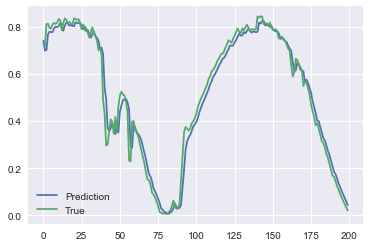

In [105]:
y_train_1 = ar_train_res.get_prediction().predicted_mean
y_test_1 = ar_test_res.get_prediction().predicted_mean
y_train_true = data_temp.iloc[:round(full_len*0.9),0].as_matrix()
y_test_true = data_temp.iloc[round(full_len*0.9) + 1:,0].as_matrix()

plt.plot(y_test_1 [-200:], label = 'Prediction')
plt.plot(y_test_true[-200:], label = 'True')
plt.legend()
print('Train 1 step ahead RMSE : {:f}'.format(np.sqrt(np.mean(np.square(y_train_true - y_train_1)))))
print('Test 1 step ahead RMSE : {:f}'.format(np.sqrt(np.mean(np.square(y_test_true - y_test_1)))))

Train 1 step ahead RMSE : 0.116521


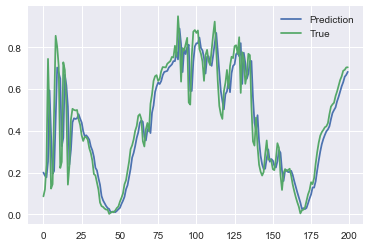

In [106]:
ar_test = sm.tsa.statespace.SARIMAX(data_temp.iloc[:,0].as_matrix(), order=(AR_order,0,0))
ar_test_res = ar_test.filter(ar_train_res.params)
y_train_1 = ar_train_res.get_prediction(dynamic = round(full_len*0.9)).predicted_mean
y_train_true = data_temp.iloc[:round(full_len*0.9),0].as_matrix()
print('Train 1 step ahead RMSE : {:f}'.format(np.sqrt(np.mean(np.square(y_train_true - y_train_1)))))

plt.plot(y_train_1 [-200:], label = 'Prediction')
plt.plot(y_train_true[-200:], label = 'True')
plt.legend()

# 3.1 Auto Regressive (AR)

In [107]:
def get_batch_AR(X, steps, cur_index):
    
    y = X[cur_index:cur_index+steps]
    
    return y

In [115]:
arr_train_mse = []
arr_dev_mse = []

for j in range(5, 6):
    forecast_steps = 24
    test_set_ratio = 0.05

    AR_order = (j,0,0)       # p d q
    Season_order = (0,0,0,0) # P D Q Lag
    n_group = 2

    data_temp = data_group_all[n_group]
    full_len = data_group_all[n_group].shape[0]

    len_train = round(full_len*(1-test_set_ratio))

    data_train = data_temp.iloc[:len_train, 0].as_matrix()
    data_test = data_temp.iloc[len_train+1:, 0].as_matrix()

    # fit data only on the train data
    ar_train = sm.tsa.statespace.SARIMAX(data_train, order=AR_order, seasonal_order=Season_order, simple_differencing=False)
    ar_train_res = ar_train.fit()
    params = ar_train_res.params  # get train parameters

    # evaluate of 3 hours steps forecast on train and dev set
    data_train_temp = data_train.copy()
    new_full_len = len_train
    arr_y_dev = []

    for k in range(0, len(data_test), forecast_steps):

        data_dev_temp = get_batch_AR(data_test, forecast_steps, k)
        data_train_temp = np.concatenate((data_train_temp, data_dev_temp))

        ar_test = sm.tsa.statespace.SARIMAX(data_train_temp, order=AR_order, seasonal_order=Season_order)
        ar_test_res = ar_test.filter(params)
        y_all_dev = ar_test_res.get_prediction(dynamic = new_full_len).predicted_mean

        y_dev = y_all_dev[-data_dev_temp.shape[0]:] # extract only last inserted test data
        arr_y_dev.extend(y_dev)

        new_full_len += data_dev_temp.shape[0]

    # get predicted of train set
    y_train = ar_train_res.get_prediction(dynamic = len_train - forecast_steps).predicted_mean
    print(len_train - forecast_steps)
    
    train_mse = np.sqrt(np.mean(np.square(np.array(y_train)[-forecast_steps:] - data_train[-forecast_steps:])))
    dev_mse = np.sqrt(np.mean(np.square(np.array(arr_y_dev) - data_test)))
    
    arr_train_mse.append(train_mse)
    arr_dev_mse.append(dev_mse)

    print('AR Order ({:d}, 0, 0)\nTrain RMSE : {:6f} \nDev RMSE : {:6f}'.format(j, train_mse, dev_mse))

14500
AR Order (5, 0, 0)
Train RMSE : 0.198325 
Dev RMSE : 0.250138


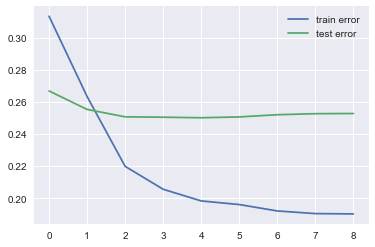

In [109]:
plt.plot(arr_train_mse,label='train error')
plt.plot(arr_dev_mse,label='test error')
plt.legend()

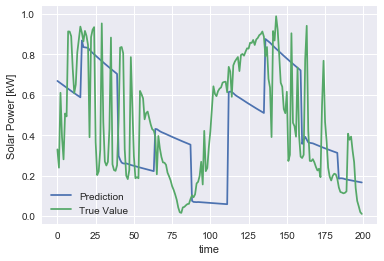

In [121]:
plt.plot(arr_y_dev[200:400], label='Prediction')
plt.plot(data_test[200:400], label='True Value')
plt.legend()
plt.xlabel('time')
plt.ylabel('Solar Power [kW]')

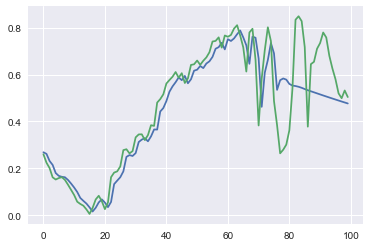

In [117]:
plt.plot(y_train[-100:])
plt.plot(data_train[-100:])

# 3.2 SARIMA
<strong> memory error! </strong>

In [154]:
arr_train_mse = []
arr_dev_mse = []

for j in range(1, 10):
    forecast_steps = 288
    test_set_ratio = 0.05

    AR_order = (j,1,0)       # p d q
    Season_order = (1,0,0,288) # P D Q Lag
    n_group = 0

    data_temp = data_group_all[n_group]
    full_len = data_group_all[n_group].shape[0]

    len_train = round(full_len*(1-test_set_ratio))

    data_train = data_temp.iloc[:len_train, 0].as_matrix()
    data_test = data_temp.iloc[len_train+1:, 0].as_matrix()

    # fit data only on the train data
    ar_train = sm.tsa.statespace.SARIMAX(data_train, order=AR_order, seasonal_order=Season_order, simple_differencing=False)
    ar_train_res = ar_train.fit()
    params = ar_train_res.params  # get train parameters

    # evaluate of 3 hours steps forecast on train and dev set
    data_train_temp = data_train.copy()
    new_full_len = len_train
    arr_y_dev = []

    for k in range(0, len(data_test), forecast_steps):

        data_dev_temp = get_batch_AR(data_test, forecast_steps, k)
        data_train_temp = np.concatenate((data_train_temp, data_dev_temp))

        ar_test = sm.tsa.statespace.SARIMAX(data_train_temp, order=AR_order, seasonal_order=Season_order)
        ar_test_res = ar_test.filter(params)
        y_all_dev = ar_test_res.get_prediction(dynamic = new_full_len).predicted_mean

        y_dev = y_all_dev[-data_dev_temp.shape[0]:] # extract only last inserted test data
        arr_y_dev.extend(y_dev)

        new_full_len += data_dev_temp.shape[0]

    # get predicted of train set
    y_train = ar_train_res.get_prediction(dynamic = len_train - forecast_steps).predicted_mean
    
    train_mse = np.sqrt(np.mean(np.square(np.array(y_train)[-forecast_steps:] - data_train[-forecast_steps:])))
    dev_mse = np.sqrt(np.mean(np.square(np.array(arr_y_dev) - data_test)))
    
    arr_train_mse.append(train_mse)
    arr_dev_mse.append(dev_mse)

    print('AR Order ({:d}, 0, 0)\nTrain RMSE : {:6f} \nDev RMSE : {:6f}'.format(j, train_mse, dev_mse))

MemoryError: 